Importing the fastai libary for image recognition and others used in the model

In [2]:
from fastai.vision.all import *
from torchvision.models import *
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

Here I create paths to the different data in my dataset

In [3]:
data_path = Path('/kaggle/input/chexpert')
path_train = Path('/kaggle/input/chexpert/CheXpert-v1.0-small/train')
path_valid = Path('/kaggle/input/chexpert/CheXpert-v1.0-small/valid')

Gets the csv files for training and validation

In [4]:
train_df = pd.read_csv(data_path/'CheXpert-v1.0-small/train.csv')
valid_df = pd.read_csv(data_path/'CheXpert-v1.0-small/valid.csv')

Looking at what the csv files are containing 

In [5]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [6]:
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg,Male,70,Lateral,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exploring the data for NaN values

In [7]:
train_df.isna().sum()

Path                               0
Sex                                0
Age                                0
Frontal/Lateral                    0
AP/PA                          32387
No Finding                    201033
Enlarged Cardiomediastinum    178575
Cardiomegaly                  177211
Lung Opacity                  105636
Lung Lesion                   211470
Edema                         137458
Consolidation                 152792
Pneumonia                     195806
Atelectasis                   154971
Pneumothorax                  144480
Pleural Effusion               90203
Pleural Other                 216922
Fracture                      211220
Support Devices               100197
dtype: int64

In [8]:
valid_df.isna().sum()

Path                           0
Sex                            0
Age                            0
Frontal/Lateral                0
AP/PA                         32
No Finding                     0
Enlarged Cardiomediastinum     0
Cardiomegaly                   0
Lung Opacity                   0
Lung Lesion                    0
Edema                          0
Consolidation                  0
Pneumonia                      0
Atelectasis                    0
Pneumothorax                   0
Pleural Effusion               0
Pleural Other                  0
Fracture                       0
Support Devices                0
dtype: int64

Making a list of the targets we are looking to find

In [9]:
    chexnet_targets = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Handles the NaN values by filling them in with the value 0, and making any uncertain answers to 1 (this is not the best solution but the one we got time for, when working with this project later this will be a focus point in making a better model)

In [10]:
train_df = train_df.fillna(0)
train_df[chexnet_targets] = train_df[chexnet_targets].abs()

In [11]:
valid_df = valid_df.fillna(0)

Look over the data after filling in NaN values and converting the -1 values to 1

In [12]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CheXpert-v1.0-small/train/patient00002/study1/view2_lateral.jpg,Female,83,Lateral,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
valid_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg,Male,73,Frontal,AP,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg,Male,70,Frontal,PA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg,Male,70,Lateral,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg,Male,85,Frontal,AP,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg,Female,42,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Making the functions for getting the pictures path (get_x) that will be used by our vision learner

Making the function for finding wich condition the patient has (get_y)

In [14]:
def get_x(row): 
    return data_path / row['Path']

def get_y(row):
    condition_columns = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
    labels = [i for i in condition_columns if row[i]== 1]
    return labels

Combining the csv files into one singular csv file, but making sure to mark what was in the validation set so that we can use this later

In [15]:
combined_df = pd.concat([train_df, valid_df], ignore_index=True)

valid_idx_start = len(train_df)

valid_idx = list(range(valid_idx_start, len(combined_df)))

Making the datablock that will be used later

In [16]:
datablock = DataBlock(
    blocks = (ImageBlock, MultiCategoryBlock),
    splitter = IndexSplitter(valid_idx),
    get_x = get_x,
    get_y = get_y,
    item_tfms = Resize(256),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
)

Making the dataloader with the new csv file and showing three images for one of the batches

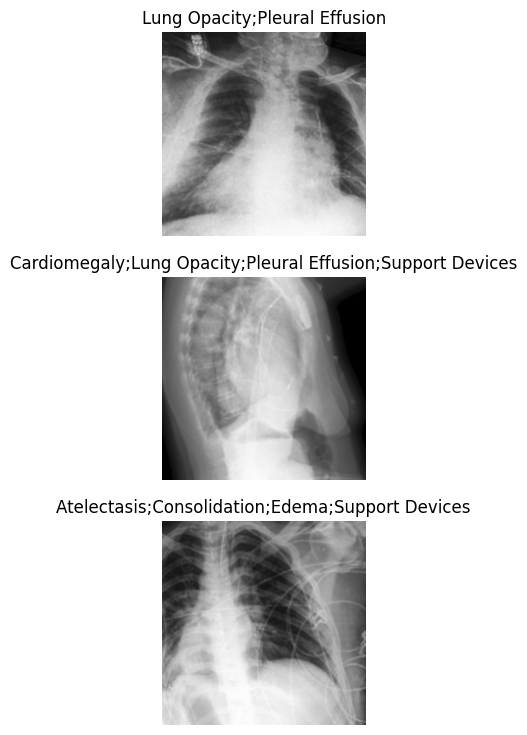

In [ ]:
dls = datablock.dataloaders(combined_df, bs=32)
dls.show_batch(nrows=3, ncols=1)

Training the model on out dataset, here we choose to use the resnet18 pre-trained model. For metrics we used the accuracy_multi that will give a accuracy for each condition and we set a threshold of 0,5 so that the model will only say the condition is present if it is 50% or more sure that it is present

Under we find a learning rate and we get three different options and choose the one that looks the best

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 136MB/s] 


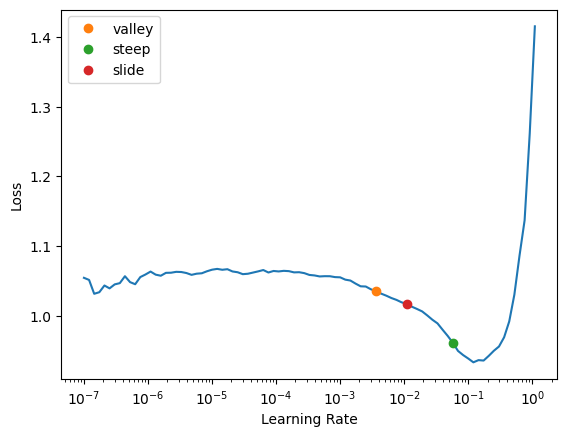

In [18]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.5))
lr = learn.lr_find(suggest_funcs=(valley, steep, slide))

Here we train the model with the choosen learning rate

In [19]:
learn.fit_one_cycle(3, lr.slide)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.398848,0.418477,0.821123,24:51
1,0.378663,0.408747,0.832723,11:55
2,0.367055,0.401459,0.834554,11:53


Here we present the cases with the higghest loss in our validation set. We get to see what conditions the patient had but also what the model predictet in additon to the different probabilities

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, figsize=(15,10))

,target,predicted,probabilities,loss
0,Atelectasis;Cardiomegaly;Consolidation;Enlarged Cardiomediastinum;Lung Opacity;Support Devices,Lung Opacity,"tensor([1.2768e-02, 4.5815e-05, 1.7132e-03, 2.6157e-01, 4.1578e-04, 1.0952e-06,\n 6.5042e-07, 9.2425e-01, 5.0206e-06, 1.7440e-01, 3.8962e-08, 2.6961e-03,\n 2.0387e-04, 9.6816e-02])",2.2441043853759766
1,Atelectasis;Cardiomegaly;Edema;Enlarged Cardiomediastinum;Lung Opacity;Pleural Effusion;Support Devices,Edema;Lung Opacity,"tensor([0.4075, 0.0329, 0.2378, 0.5177, 0.0137, 0.0025, 0.0079, 0.5415, 0.0450,\n 0.4461, 0.0018, 0.1459, 0.1647, 0.1008])",0.9743325114250183
2,Atelectasis;Enlarged Cardiomediastinum;Lung Lesion;Lung Opacity;Support Devices,,"tensor([0.3882, 0.0498, 0.1622, 0.2670, 0.0328, 0.0149, 0.0095, 0.4646, 0.0939,\n 0.1331, 0.0043, 0.0870, 0.3792, 0.2310])",0.9017658829689026
3,Atelectasis;Cardiomegaly;Consolidation;Edema;Enlarged Cardiomediastinum;Lung Opacity;Pleural Effusion;Support Devices,Atelectasis;Edema;Lung Opacity,"tensor([0.5061, 0.0373, 0.2709, 0.6016, 0.0210, 0.0037, 0.0081, 0.5855, 0.0324,\n 0.4866, 0.0011, 0.1409, 0.0686, 0.2934])",0.8855029344558716
4,Atelectasis;Cardiomegaly;Edema;Enlarged Cardiomediastinum;Lung Opacity;Support Devices,Edema;Lung Opacity,"tensor([0.1067, 0.0380, 0.1310, 0.6997, 0.0170, 0.0050, 0.0106, 0.5951, 0.0181,\n 0.1558, 0.0060, 0.3105, 0.1260, 0.3454])",0.8840622901916504


In the next cells we set up a multilabel condusion matrix to se what conditions the model preforms well at and where the model preforms bad.

In [21]:
from sklearn.metrics import multilabel_confusion_matrix

# Get predictions
preds, targs = learn.get_preds()

# Convert predictions to binary using a threshold (e.g., 0.5)
binary_preds = preds > 0.5

# Calculate confusion matrix for each label
cm = multilabel_confusion_matrix(targs, binary_preds)

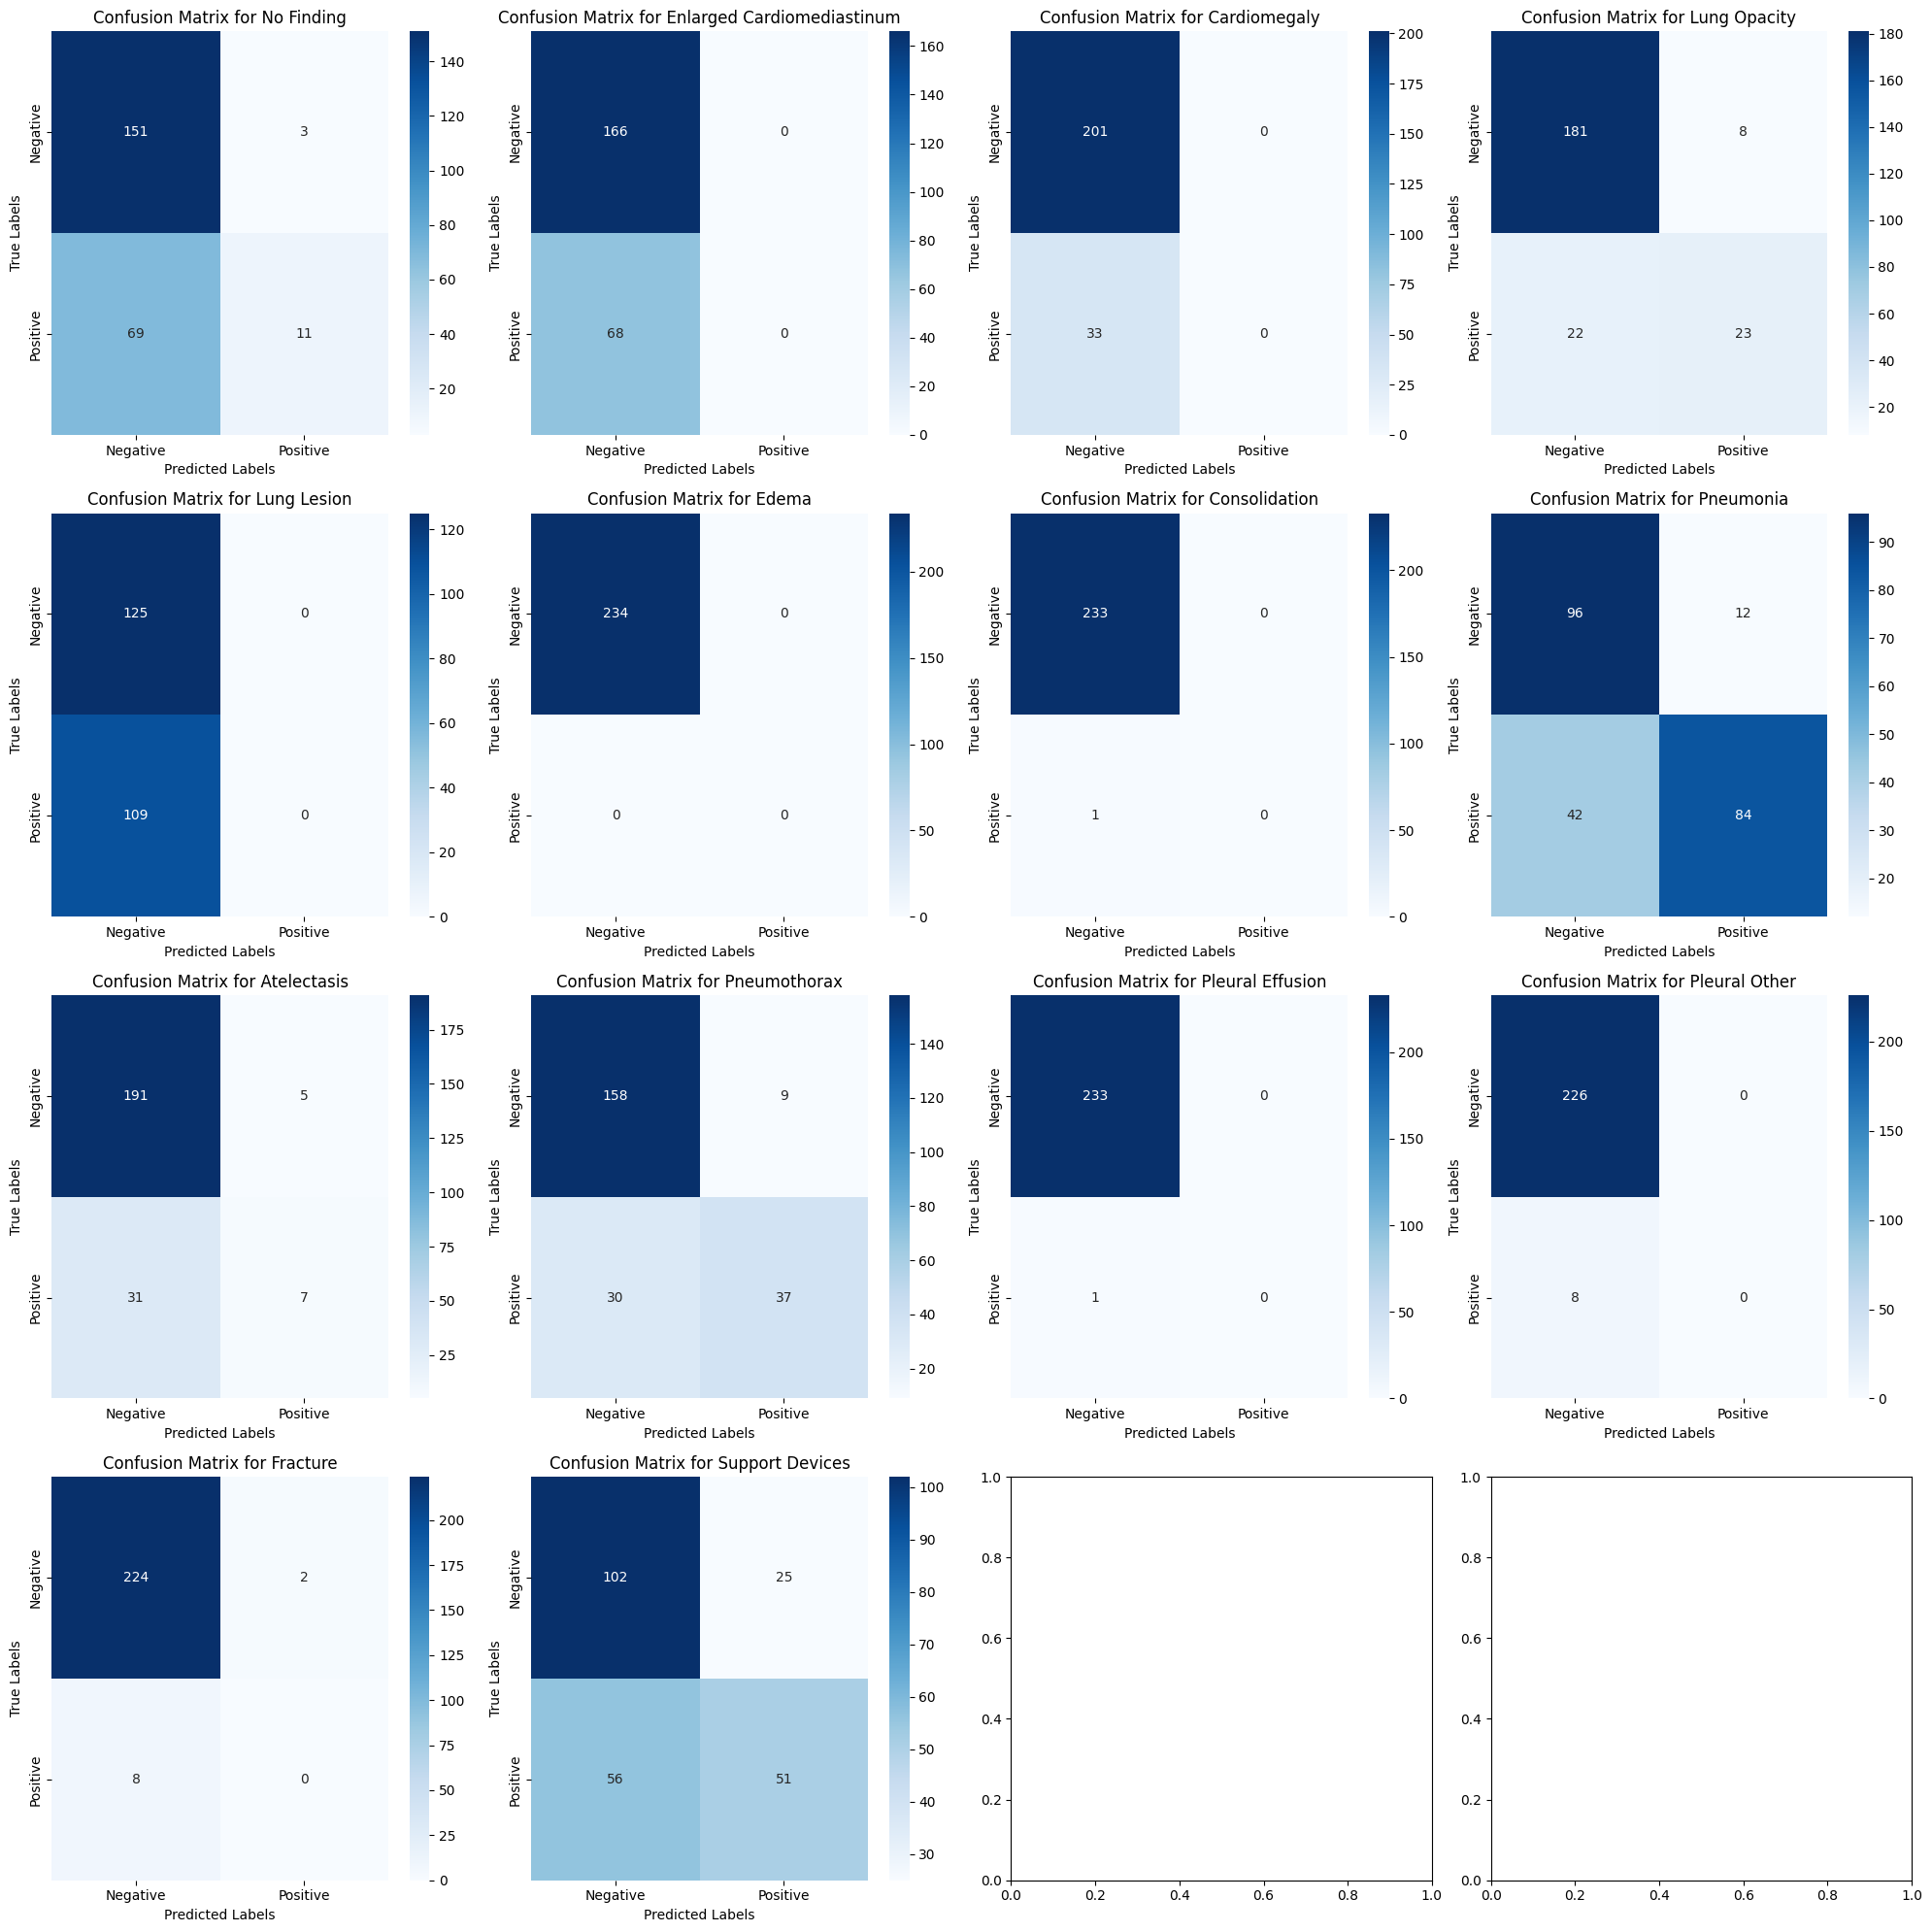

In [22]:
import seaborn as sns

def plot_confusion_matrix(cm, label, ax=None):
    """
    Plots a confusion matrix using seaborn's heatmap.
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {label}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])

# Plot the confusion matrix for each label
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
axes = axes.flatten()
for i, label in enumerate(chexnet_targets):
    plot_confusion_matrix(cm[i], label, ax=axes[i])
plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


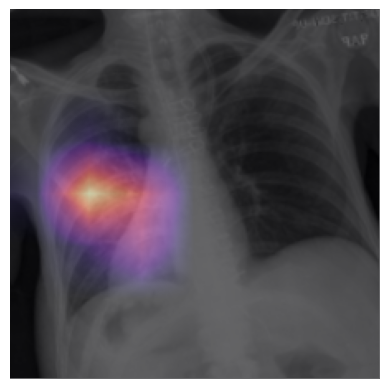

In [23]:
def grad_cam(learn, x, class_id=None):
    # Get the model's last convolutional layer
    target_layer = learn.model[0][-1]
    
    # Hook the feature extractor
    features = {}
    def get_features_hook(module, input, output):
        features["conv_features"] = output.detach()
    
    handle_features = target_layer.register_forward_hook(get_features_hook)
    
    # Hook for the gradients
    gradients = {}
    def get_gradients_hook(module, grad_input, grad_output):
        gradients["conv_gradients"] = grad_output[0].detach()
    
    handle_gradients = target_layer.register_backward_hook(get_gradients_hook)
    
    # Forward pass
    output = learn.model.eval()(x)
    if class_id is None:
        class_id = output.argmax(dim=1).item()
    
    # Zero gradients
    learn.model.zero_grad()
    
    # Backward pass for the selected class
    target = output[:, class_id]
    target.backward()
    
    # Get the features and gradients
    conv_features = features["conv_features"]
    conv_gradients = gradients["conv_gradients"]
    
    # Pool the gradients across the channels
    pooled_gradients = torch.mean(conv_gradients, dim=[0, 2, 3])
    
    # Weight the channels by corresponding gradients
    for i in range(conv_features.shape[1]):
        conv_features[:, i, :, :] *= pooled_gradients[i]
    
    # Average the channels of the features
    heatmap = torch.mean(conv_features, dim=1).squeeze()
    heatmap = np.maximum(heatmap.cpu().numpy(), 0)
    heatmap /= np.max(heatmap)
    
    # Cleanup hooks
    handle_features.remove()
    handle_gradients.remove()
    
    return heatmap


def plot_heatmap(heatmap, ax, alpha=0.6):
    img = TensorImage(dls.train.decode((x,))[0][0])  # Decode to get the image
    img.show(ctx=ax)  # Show the image
    ax.imshow(heatmap, alpha=alpha, extent=(0, 224, 224, 0),
              interpolation='bilinear', cmap='magma')

# Usage
x, _ = dls.one_batch()
x = x[0].unsqueeze(0).cuda()  # Use the first image of the batch and ensure it's on GPU
class_id = None  # Auto-select the class based on model prediction or specify it

heatmap = grad_cam(learn, x, class_id=class_id)

_, ax = plt.subplots()
plot_heatmap(heatmap, ax)



In [24]:
def grad_cam_batch(learn, xb, class_ids=None):
    """
    Generate Grad-CAM heatmaps for a batch of images.
    
    Args:
    learn (Learner): The fastai learner with a convolutional model.
    xb (Tensor): A batch of images, expected shape [N, C, H, W].
    class_ids (list of int, optional): List of class IDs for which to generate the Grad-CAM.
        If None, the class with the highest output score is used for each image.
    
    Returns:
    List[Tensor]: A list of heatmaps for each image in the batch.
    """
    # Ensure model is in evaluation mode and move input to same device as model
    m = learn.model.eval()
    xb = xb.to(learn.dls.device)

    # Hook the feature extractor
    features = {}
    def hook_features(module, input, output):
        features['conv_features'] = output.detach()

    # Hook the gradients
    gradients = {}
    def hook_gradients(module, grad_in, grad_out):
        gradients['conv_gradients'] = grad_out[0].detach()

    # Register hooks on the last convolutional layer
    hook_f = m[0][-1].register_forward_hook(hook_features)
    hook_b = m[0][-1].register_backward_hook(hook_gradients)

    # Forward pass to get model predictions
    preds = m(xb)
    if class_ids is None:
        # If no class IDs provided, use the class with the highest output score
        class_ids = preds.argmax(dim=1).tolist()

    heatmaps = []
    for i, class_id in enumerate(class_ids):
        one_hot = torch.zeros_like(preds[i])
        one_hot[class_id] = 1
        preds[i].backward(one_hot, retain_graph=True if i < len(class_ids)-1 else False)

        # Get features and gradients for the current image
        conv_features = features['conv_features'][i].unsqueeze(0)
        conv_gradients = gradients['conv_gradients'][i].unsqueeze(0)

        # Pool the gradients across the channels and weight the channels
        pooled_gradients = torch.mean(conv_gradients, dim=[0, 2, 3])
        weighted_features = torch.zeros_like(conv_features)
        for j in range(conv_features.shape[1]):
            weighted_features[:, j, :, :] = conv_features[:, j, :, :] * pooled_gradients[j]

        # Generate heatmap by averaging across channels and applying ReLU
        heatmap = torch.mean(weighted_features, dim=1).squeeze()
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmaps.append(heatmap.cpu())

    # Remove hooks
    hook_f.remove()
    hook_b.remove()

    return heatmaps, class_ids


In [25]:
def plot_batch_with_heatmaps(dls, xb, heatmaps, class_ids):
    """
    Plots a batch of images with their corresponding Grad-CAM heatmaps.
    
    Args:
    dls (DataLoaders): The fastai dataloaders, used for decoding batch.
    xb (Tensor): The batch of images.
    heatmaps (list of Tensor): A list of heatmaps corresponding to xb.
    """
    
    nrows = len(xb)
    ncols = 2  # For each row: [Original Image, Heatmap]
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*5))
    
    for i in range(nrows):
        # Decode and show original image
        img = dls.train.decode((xb[i:i+1],))[0][0]
        img.show(ctx=axs[i, 0] if nrows > 1 else axs[0])
        axs[i, 0].set_title('Original Image')
        
        # Show heatmap
        axs[i, 1].imshow(img.permute(1, 2, 0).cpu().numpy())
        axs[i, 1].imshow(heatmaps[i], alpha=0.5, extent=(0, img.shape[2], img.shape[1], 0),
                         cmap='jet')
        # Use class_id for the title if available, can be replaced with class names if you have a mapping
        class_name = dls.vocab[class_ids[i]]
        axs[i, 1].set_title(f'Grad-CAM: Class {class_name}')
    
    plt.tight_layout()
    plt.show()


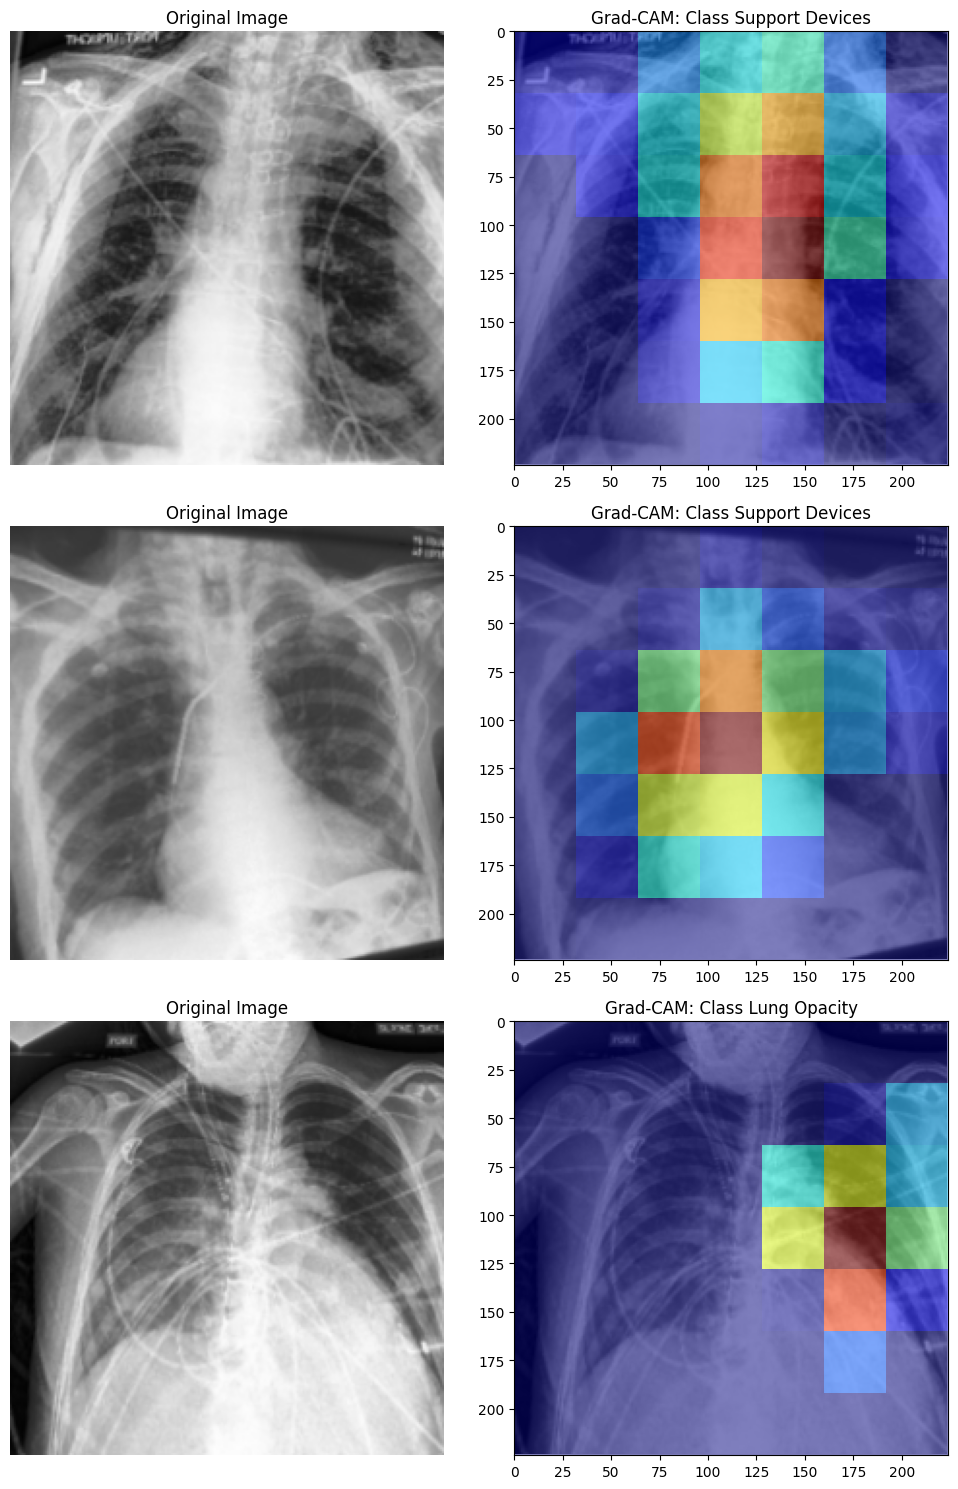

In [27]:
# Get a batch of images
xb, _ = dls.one_batch()

# Generate class IDs if you have specific targets, else None to use the highest scoring class
class_ids = None  # Example: [0, 1, 2] for the first three classes, if specific classes are targeted

# Generate heatmaps
heatmaps, class_ids = grad_cam_batch(learn, xb[:3], class_ids=class_ids)  # Using the first 3 images of the batch

# Visualize
plot_batch_with_heatmaps(dls, xb[:3], heatmaps, class_ids)
